In [1]:
# Import Standard Libraries
import os
import tarfile
import time
import random
import glob
from PIL import Image
from collections import Counter
from tqdm.auto import tqdm

#Plotting
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Import PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets

# Install and Import timm for transformer architecture
!pip install timm -q
import timm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
def extract_tar_xz(tar_file_path, extract_to_path):
    """
    Extracts the contents of a .tar.xz file to a specified directory.

    Input:
    - tar_file_path (str): The path to the .tar.xz archive file to be extracted.
    - extract_to_path (str): The directory path where the contents will be extracted.

    Output:
    - None: The function performs an extraction operation and does not return a value.
    """

    # Creates the specified directory if it doesn't already exist
    os.makedirs(extract_to_path, exist_ok=True)

    # Opens the specified .tar.xz file in read mode
    with tarfile.open(tar_file_path, 'r:xz') as tar:
        print("Extracting files...")

        # Extracts all files from the .tar.xz archive to the specified directory
        tar.extractall(path=extract_to_path)

        print("Extraction completed successfully!")


#File Paths
tar_file_path = '/content/drive/My Drive/huron_unlabeled_data.tar.xz'
unlabelled_data = '/content/unlabelled_data'

extract_tar_xz(tar_file_path, unlabelled_data)

Extracting files...
Extraction completed successfully!


In [3]:
class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, global_transform=None, local_transform=None, num_global_views=2, num_local_views=4):
        """
        Initializes the UnlabeledDataset.

        Input:
        - image_dir (str): The directory containing the image files.
        - global_transform (callable, optional): Transformations applied to generate global views.
        - local_transform (callable, optional): Transformations applied to generate local views.
        - num_global_views (int): Number of global views per image.
        - num_local_views (int): Number of local views per image.

        Output:
        - None: This initializer sets up attributes needed to handle the dataset.
        """

        # Initialize the image directory and retrieve image files
        self.image_dir = image_dir
        self.image_files = glob.glob(os.path.join(image_dir, '**', '*'), recursive=True)

        # Check if any image files were found, otherwise print a warning
        if not self.image_files:
            print("No image files found. Check the extraction path and file extensions.")
        else:
            print(f"Number of images found: {len(self.image_files)}")

        # Store the transformations and number of views
        self.global_transform = global_transform
        self.local_transform = local_transform
        self.num_global_views = num_global_views
        self.num_local_views = num_local_views

    def __len__(self):

        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Retrieves an image and applies transformations to create multiple views.

        Input:
        - idx (int): Index of the image in the dataset.

        Output:
        - list: A list of augmented views for the specified image.
        """

        # Get the path for the image at the specified index
        img_path = self.image_files[idx]

        # Try to open the image, skipping it if an error occurs
        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, OSError) as e:
            print(f"Error loading image at {img_path}: {e}")
            return None

        # Generate multiple augmented views of the image
        views = []

        # Apply global transformations
        for i in range(self.num_global_views):
            if isinstance(self.global_transform, list):
                # Apply each global transform in the list once.
                views.append(self.global_transform[i](image))
            else:
                # If it's a single transform, just apply it repeatedly
                views.append(self.global_transform(image))

        # Apply local transformations
        for _ in range(self.num_local_views):
            if self.local_transform:
                views.append(self.local_transform(image))

        return views


In [4]:
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode

# ImageNet normalization parameters
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

# Global crops transformation parameters
global_crop_size = 224
global_crop_scale = (0.14, 1.0)

# Local crops transformation parameters
local_crop_size = 96
local_crop_scale = (0.05, 0.14)

# Color jitter parameters
color_jitter_strength = 0.4
color_jitter = transforms.ColorJitter(
    brightness=color_jitter_strength,
    contrast=color_jitter_strength,
    saturation=color_jitter_strength * 0.5,
    hue=0.1
)

# Gaussian blur parameters
gaussian_blur = transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))

# 1. First global transformation (no solarization)
global_transform_1 = transforms.Compose([
    transforms.RandomResizedCrop(global_crop_size, scale=global_crop_scale, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([color_jitter], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([gaussian_blur], p=1.0),  # Always blur
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# 2. Second global transformation (includes solarization)
global_transform_2 = transforms.Compose([
    transforms.RandomResizedCrop(global_crop_size, scale=global_crop_scale, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([color_jitter], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([gaussian_blur], p=0.1),  # Blur with lower probability
    transforms.RandomSolarize(threshold=128, p=0.2),  # Solarization
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# Define the local transformation
local_transform = transforms.Compose([
    transforms.RandomResizedCrop(96, scale=(0.05, 0.14), interpolation=InterpolationMode.BICUBIC),
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([color_jitter], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([gaussian_blur], p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


In [5]:
# Create the dataset
dataset = UnlabeledDataset(
    image_dir=unlabelled_data,
    global_transform=[global_transform_1, global_transform_2],  # two distinct global transforms
    local_transform=local_transform,
    num_global_views=2,
    num_local_views=4
)

# Create a DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

batch = next(iter(dataloader))

print("Number of views per batch:", len(batch))  # Expect 6 (2 global + 4 local)
for i, views in enumerate(batch):
    print(f"View {i}: shape = {views.shape}")


Number of images found: 16353
Number of views per batch: 6
View 0: shape = torch.Size([32, 3, 224, 224])
View 1: shape = torch.Size([32, 3, 224, 224])
View 2: shape = torch.Size([32, 3, 224, 224])
View 3: shape = torch.Size([32, 3, 224, 224])
View 4: shape = torch.Size([32, 3, 224, 224])
View 5: shape = torch.Size([32, 3, 224, 224])


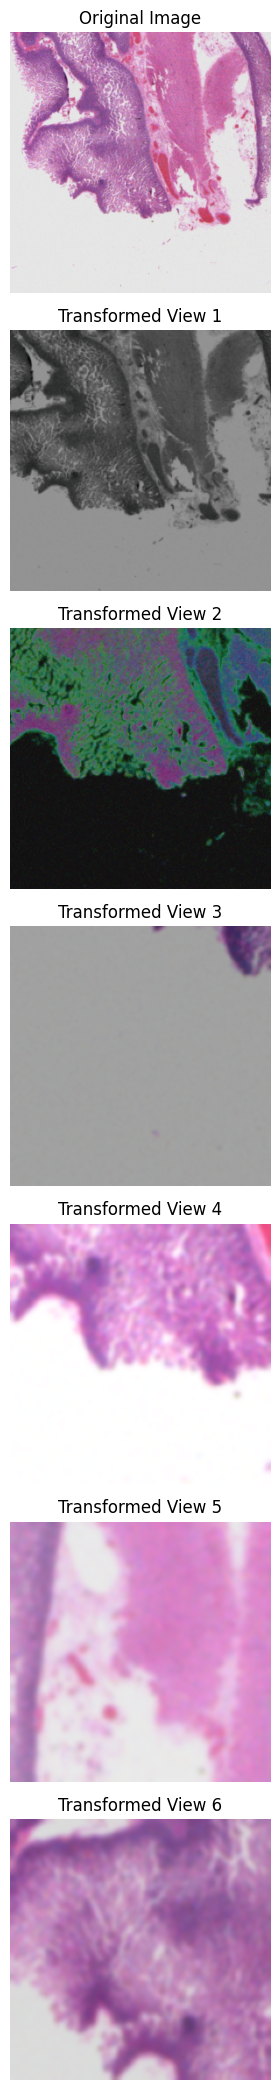

In [6]:
# Function to denormalize a tensor image
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# ImageNet normalization parameters used in the transformations
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

# Choose an index to visualize
idx = torch.randint(0, len(dataset), (1,)).item()

# Retrieve the transformed views for this image
views = dataset[idx]  # views is a list of tensors: [2 global views + 4 local views]

# Load the original image again (untransformed) for comparison
img_path = dataset.image_files[idx]
original_image = Image.open(img_path).convert('RGB')

num_views = len(views)
fig, axes = plt.subplots(nrows=num_views+1, ncols=1, figsize=(6, 3*(num_views+1)))

if num_views == 1:
    axes = [axes]

# Show the original image
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Show each transformed view
for i, v in enumerate(views, start=1):
    v_denorm = denormalize(v, imagenet_mean, imagenet_std)
    pil_img = to_pil_image(v_denorm.clamp(0,1))

    axes[i].imshow(pil_img)
    axes[i].set_title(f"Transformed View {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
del dataset.image_files[0]

In [ ]:
class DINOHead(nn.Module):
    def __init__(
        self,
        in_dim,
        out_dim,
        use_bn=False,
        nlayers=3,
        hidden_dim=2048,
        bottleneck_dim=256,
        norm_last_layer=True
    ):
        """
        Args:
            in_dim (int): Dimension of the input features (e.g., ViT embedding dimension).
            out_dim (int): Dimension of the output features (e.g., projection dimension for DINO).
            use_bn (bool): Whether to use BatchNorm in the MLP.
            nlayers (int): Number of layers in the MLP (including the last one).
            hidden_dim (int): Dimension of hidden layers in the MLP.
            bottleneck_dim (int): Dimension of the layer before the final linear layer.
            norm_last_layer (bool): Whether to freeze the magnitude (weight_g) of the last layer’s weights.
        """
        super(DINOHead, self).__init__()
        nlayers = max(nlayers, 1)
        layers = []

        if nlayers == 1:
            layers.append(nn.Linear(in_dim, bottleneck_dim))
        else:
            # Multiple layers:
            layers.append(nn.Linear(in_dim, hidden_dim))
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())

            for _ in range(nlayers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                if use_bn:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.GELU())

            layers.append(nn.Linear(hidden_dim, bottleneck_dim))

        self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)

        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1.0)

        if norm_last_layer:
            # Freeze the scale parameter (weight_g) of the last layer
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Pass through MLP
        x = self.mlp(x)
        # Normalize the output of the MLP before the final layer
        x = F.normalize(x, dim=-1, p=2)
        # Pass through the last layer
        x = self.last_layer(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DINOLoss(nn.Module):
    def __init__(
        self,
        out_dim,
        warmup_teacher_temp,
        teacher_temp,
        warmup_teacher_temp_epochs,
        nepochs,
        student_temp=0.1,
        center_momentum=0.9,
        device="cuda"
    ):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.register_buffer("center", torch.zeros(1, out_dim).to(device))

        self.warmup_teacher_temp = warmup_teacher_temp
        self.teacher_temp = teacher_temp
        self.warmup_teacher_temp_epochs = warmup_teacher_temp_epochs
        self.nepochs = nepochs
        self.device = device

    def _get_teacher_temp(self, epoch):
        if epoch < self.warmup_teacher_temp_epochs:
            return self.warmup_teacher_temp + (
                (self.teacher_temp - self.warmup_teacher_temp) * epoch / self.warmup_teacher_temp_epochs
            )
        else:
            return self.teacher_temp

    @torch.no_grad()
    def update_center(self, teacher_output):
        batch_center = torch.mean(teacher_output, dim=0, keepdim=True)
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

    def forward(self, student_outputs, teacher_outputs, epoch):
        num_global_views = 2
        batch_size = student_outputs[0].shape[0]
        out_dim = self.center.shape[1]

        # Reshape teacher outputs: [batch_size, num_global_views, out_dim]
        teacher_outputs = teacher_outputs.view(batch_size, num_global_views, out_dim)

        # Get current teacher temperature and compute probabilities
        cur_teacher_temp = self._get_teacher_temp(epoch)
        teacher_probs = F.softmax((teacher_outputs - self.center) / cur_teacher_temp, dim=-1)  # [batch_size, num_global_views, out_dim]

        # Compute student probabilities for each view
        student_probs = torch.stack([F.softmax(s / self.student_temp, dim=-1) for s in student_outputs], dim=1)  # [batch_size, num_student_views, out_dim]

        # Cross-entropy loss between teacher and student views
        # teacher_probs: [batch_size, num_global_views, out_dim]
        # student_probs: [batch_size, num_student_views, out_dim]
        loss_matrix = -torch.einsum('btd,bsd->bt', teacher_probs, torch.log(student_probs + 1e-8))  # [batch_size, num_global_views]
        total_loss = loss_matrix.mean()

        # Update the center
        with torch.no_grad():
            teacher_flat = teacher_probs.view(batch_size * num_global_views, out_dim)
            self.update_center(teacher_flat)

        return total_loss


In [ ]:
def create_vit_backbone(model_name="vit_tiny_patch16_224", pretrained=False):
    """
    Creates a ViT backbone using timm.

    Args:
        model_name (str): ViT variant from timm.
        pretrained (bool): Whether to load ImageNet pretrained weights.

    Returns:
        timm model: A ViT model without final classification head.
    """
    # Create a ViT model; num_classes=0 ensures no final classifier head is attached
    vit = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
    return vit

def initialize_models(
    model_name="vit_tiny_patch16_224",
    student_out_dim=65536,
    teacher_out_dim=65536,
    hidden_dim=2048,
    bottleneck_dim=256,
    checkpoint_path=None,
    device="cuda"
):
    # Create student and teacher backbones
    student_backbone = create_vit_backbone(model_name=model_name, pretrained=False).to(device)
    teacher_backbone = create_vit_backbone(model_name=model_name, pretrained=False).to(device)

    # Freeze teacher backbone parameters (teacher is only updated via EMA)
    for p in teacher_backbone.parameters():
        p.requires_grad = False

    # Create student and teacher heads
    student_head = DINOHead(
        in_dim=student_backbone.embed_dim,
        out_dim=student_out_dim,
        nlayers=3,
        hidden_dim=hidden_dim,
        bottleneck_dim=bottleneck_dim,
        norm_last_layer=True
    ).to(device)

    teacher_head = DINOHead(
        in_dim=teacher_backbone.embed_dim,
        out_dim=teacher_out_dim,
        nlayers=3,
        hidden_dim=hidden_dim,
        bottleneck_dim=bottleneck_dim,
        norm_last_layer=True
    ).to(device)

    # Freeze teacher head parameters as well
    for p in teacher_head.parameters():
        p.requires_grad = False

    optimizer = torch.optim.AdamW(list(student_backbone.parameters()) + list(student_head.parameters()), lr=1e-4, weight_decay=0.05)

    # Initialize a DINO loss
    dino_loss_fn = DINOLoss(
        out_dim=student_out_dim,
        warmup_teacher_temp=0.04,
        teacher_temp=0.07,
        warmup_teacher_temp_epochs=10,
        nepochs=10,
        student_temp=0.1,
        center_momentum=0.9,
        device=device
    ).to(device)

    # If a checkpoint path is provided and it exists, load it
    start_epoch = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Load student and teacher state_dicts
        student_backbone.load_state_dict(checkpoint['student_backbone'])
        student_head.load_state_dict(checkpoint['student_head'])
        teacher_backbone.load_state_dict(checkpoint['teacher_backbone'])
        teacher_head.load_state_dict(checkpoint['teacher_head'])

        # Load optimizer state_dict if available
        if 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])

        # Load DINO loss center if available
        if 'center' in checkpoint:
            dino_loss_fn.center = checkpoint['center'].to(device)

        # Load epoch
        if 'epoch' in checkpoint:
            start_epoch = checkpoint['epoch'] + 1

        print(f"Resumed training from epoch {start_epoch}")

    return (student_backbone, student_head,
            teacher_backbone, teacher_head,
            optimizer, dino_loss_fn, start_epoch)

In [ ]:
def dino_teacher_momentum_schedule(base_m=0.996, final_m=0.999, epoch=0, total_epochs=100):
    """
    Schedule the teacher momentum from base_m to final_m linearly over training.
    This is a commonly used schedule in DINO.
    """
    return final_m - (final_m - base_m) * (1 - min(epoch / (total_epochs - 1), 1))

def update_teacher(student_backbone, student_head, teacher_backbone, teacher_head, momentum):
    """
    Update the teacher parameters as an EMA of the student parameters.
    teacher_params = momentum * teacher_params + (1 - momentum) * student_params
    """
    with torch.no_grad():
        for param_t, param_s in zip(teacher_backbone.parameters(), student_backbone.parameters()):
            param_t.data.mul_(momentum).add_(param_s.data, alpha=1 - momentum)
        for param_t, param_s in zip(teacher_head.parameters(), student_head.parameters()):
            param_t.data.mul_(momentum).add_(param_s.data, alpha=1 - momentum)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
max_epochs = 10

# Initialize models, optimizer, and loss
checkpoint_path = None  # e.g., "/content/drive/My Drive/checkpoints/checkpoint_epoch_9.pth"
(student_backbone, student_head,
 teacher_backbone, teacher_head,
 optimizer, dino_loss_fn, start_epoch) = initialize_models(
    model_name="vit_tiny_patch16_224",
    student_out_dim=65536,
    teacher_out_dim=65536,
    hidden_dim=2048,
    bottleneck_dim=256,
    checkpoint_path=checkpoint_path,
    device=device
)

# Run the training
student_backbone.train()
student_head.train()
teacher_backbone.eval()
teacher_head.eval()

for epoch in range(start_epoch, max_epochs):
    start_time = time.time()

    # Update the teacher momentum
    momentum = dino_teacher_momentum_schedule(epoch=epoch, total_epochs=max_epochs)
    running_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{max_epochs}]", leave=True)

    for batch_idx, views in enumerate(pbar):
        # views is a list of tensors: [global_view_1, global_view_2, local_view_1, local_view_2, local_view_3, local_view_4]
        views = [v.to(device, non_blocking=True) for v in views]

        global_views = views[:2]     # 2 global views
        local_views = views[2:]      # 4 local views
        student_inputs = global_views + local_views

        # Forward pass student on all views (global and local)
        student_output = []
        for inp in student_inputs:
            s_feat = student_backbone(inp)    # [batch_size, embed_dim]
            s_out = student_head(s_feat)      # [batch_size, out_dim]
            student_output.append(s_out)

        # Forward pass teacher on global views only
        with torch.no_grad():
            teacher_output_all = []
            for g_inp in global_views:
                t_feat = teacher_backbone(g_inp)
                t_out = teacher_head(t_feat)   # [batch_size, out_dim]
                teacher_output_all.append(t_out)
            # Concatenate teacher outputs for all global views: [batch_size, num_global_views * out_dim]
            teacher_output_concat = torch.cat(teacher_output_all, dim=1)

        # Compute DINO loss
        loss = dino_loss_fn(student_output, teacher_output_concat, epoch)

        # Backprop on student
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update teacher by EMA
        update_teacher(student_backbone, student_head, teacher_backbone, teacher_head, momentum)

        running_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{max_epochs}] - Loss: {epoch_loss:.4f}, Time: {time.time()-start_time:.2f}s")

    # Save checkpoint after each epoch if a checkpoint directory is provided
    if checkpoint_dir is not None:
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        torch.save({
            'student_backbone': student_backbone.state_dict(),
            'student_head': student_head.state_dict(),
        }, checkpoint_path)

print("Training completed.")

Epoch [1/10]:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [1/10] - Loss: 36.6567, Time: 1879.31s


Epoch [2/10]:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [2/10] - Loss: 15.7259, Time: 1882.53s


Epoch [3/10]:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [3/10] - Loss: 14.8251, Time: 1875.71s


Epoch [4/10]:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [4/10] - Loss: 14.7627, Time: 1877.60s


Epoch [5/10]:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [5/10] - Loss: 14.8079, Time: 1882.51s


Epoch [6/10]:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [6/10] - Loss: 14.8422, Time: 1888.91s


Epoch [7/10]:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [7/10] - Loss: 14.8666, Time: 1881.28s


Epoch [8/10]:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [8/10] - Loss: 14.8802, Time: 1877.33s


Epoch [9/10]:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [9/10] - Loss: 14.8894, Time: 1885.31s


Epoch [10/10]:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch [10/10] - Loss: 14.8942, Time: 1875.75s
Training completed.
